# Prototype of the machine learning solution

In this script, I will implemented the approach found in the [viz.ipynb](viz.ipynb) notebook.

-----------------------------------------------

So to solve this problem we can use a non-supervised clustering algorithm to identify the clusters (this should also take care of most outliers) and then use a rule-based approach to label automatically the clusters based on the other features.

- Kangaroos: Cluster of animals that walk on 2 legs and does not have wings.
- Chickens: Cluster of animals that walk on 2 legs and have wings.
- Elephants: Cluster of animals that walk on 4 legs and are the heaviest in average.
- Dogs: Cluster of animals that walk on 4 legs and are not the heaviest in average.


First, let's load the libraries

In [1]:
%pip install "numpy>=2.2.0" "pandas>=2.0.0" "requests>=2.32.0" "scikit-learn>=1.6.0" -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

Let's load the data.

In [3]:
# This URL comes from the data service provided in the challenge
HOST = "http://localhost:8777"
DATA_ENDPOINT = f"{HOST}/api/v1/animals/data"

response = requests.get(f"{DATA_ENDPOINT}?number_of_datapoints=1000")

if response.ok:
    data = response.json()
    X = pd.DataFrame(data)

X.head()

,walks_on_n_legs,height,weight,has_wings,has_tail
0,2,0.462765,4.067066,True,True
1,2,0.331945,1.972906,True,True
2,4,0.135860,63.206962,False,True
3,2,1.801244,88.863486,False,True
4,2,1.601411,84.067925,False,True


Now let's create the clusters. After scanning through https://scikit-learn.org/stable/modules/clustering.html#clustering, I have selected the DBSCAN algorithm to create the clusters. The DBSCAN algorithm is well-known, density-based clustering algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), allowing to identify outliers.

In [4]:
model = DBSCAN(eps=0.5, min_samples=20)
trained_model = model.fit(X.loc[:, ["walks_on_n_legs", "height"]])

trained_model

DBSCAN(min_samples=20)

Let's test it on the training data. Outliers will be labelled as cluster -1.

In [5]:
X["cluster"] = trained_model.labels_

X.head()

,walks_on_n_legs,height,weight,has_wings,has_tail,cluster
0,2,0.462765,4.067066,True,True,0
1,2,0.331945,1.972906,True,True,0
2,4,0.135860,63.206962,False,True,1
3,2,1.801244,88.863486,False,True,2
4,2,1.601411,84.067925,False,True,2


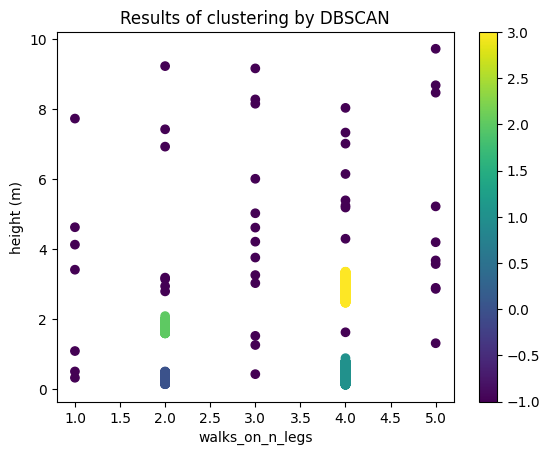

In [6]:
plt.scatter(X["walks_on_n_legs"], X["height"], c=X["cluster"])
plt.title("Results of clustering by DBSCAN")
plt.xlabel("walks_on_n_legs")
plt.ylabel("height (m)")
plt.colorbar()
plt.show()

Let's ensure we only have 5 clusters (4 clusters + 1 for outliers).

In [7]:
assert X["cluster"].nunique() == 5, (
    f"Expected 4 clusters + outliers, got {X['cluster'].nunique()}"
)

Now, let's try to name each cluster based on the other features.

In [8]:
# Filter the dataframe for elements with 2 legs and have wings
filtered_df = X[(X["walks_on_n_legs"] == 2) & (X["has_wings"])]

# Find the cluster with the highest count of such elements
chicken_cluster = filtered_df["cluster"].mode()[0]

print(f"The cluster with most elements having 2 legs and wings is: {chicken_cluster}")

The cluster with most elements having 2 legs and wings is: 0


In [9]:
# Filter the dataframe for elements with 2 legs and do not have wings
filtered_df = X[(X["walks_on_n_legs"] == 2) & (~X["has_wings"])]

# Find the cluster with the highest count of such elements
kangaroo_cluster = filtered_df["cluster"].mode()[0]

print(
    f"The cluster with most elements having 2 legs and without wings is: {kangaroo_cluster}"
)

The cluster with most elements having 2 legs and without wings is: 2


In [10]:
# Filter the dataframe for elements with 4 legs and the heaviest weight
filtered_df = X[(X["walks_on_n_legs"] == 4)].sort_values(by="weight", ascending=False)[
    : int(0.1 * len(X))
]

# Find the cluster with the highest count of such elements
elephant_cluster = filtered_df["cluster"].mode()[0]

print(
    f"The cluster with most elements having 2 legs and are the 10% heavier: {elephant_cluster}"
)

The cluster with most elements having 2 legs and are the 10% heavier: 3


In [11]:
clusters = set(X["cluster"])
# Remove known clusters
clusters.remove(-1)
clusters.remove(chicken_cluster)
clusters.remove(kangaroo_cluster)
clusters.remove(elephant_cluster)

# The last cluster must be dogs
dog_cluster = clusters.pop()
print(f"The last cluster must be dogs: {dog_cluster}")

The last cluster must be dogs: 1


In [12]:
X["cluster_names"] = X["cluster"].replace(
    {
        chicken_cluster: "chicken",
        kangaroo_cluster: "kangaroo",
        elephant_cluster: "elephant",
        dog_cluster: "dog",
        -1: "outlier",
    }
)

Let's sample the data to see if any errors are present. As we do not have the ground truth, we will have to mannually check if the clusters are correctly labelled.

In [13]:
X[X["cluster_names"] == "chicken"].sample(5)

,walks_on_n_legs,height,weight,has_wings,has_tail,cluster,cluster_names
788,2,0.285954,2.218172,True,True,0,chicken
248,2,0.284807,2.833222,True,True,0,chicken
294,2,0.265523,1.059716,True,True,0,chicken
865,2,0.480797,2.742699,True,True,0,chicken
319,2,0.223425,2.165419,True,True,0,chicken


In [14]:
X[X["cluster_names"] == "kangaroo"].sample(5)

,walks_on_n_legs,height,weight,has_wings,has_tail,cluster,cluster_names
522,2,1.855945,85.108180,False,True,2,kangaroo
984,2,1.948787,61.376201,False,True,2,kangaroo
425,2,1.803564,86.925053,False,True,2,kangaroo
595,2,1.941590,85.645043,False,True,2,kangaroo
329,2,1.805051,54.792867,False,True,2,kangaroo


In [15]:
X[X["cluster_names"] == "elephant"].sample(5)

,walks_on_n_legs,height,weight,has_wings,has_tail,cluster,cluster_names
423,4,3.269643,5247.341616,False,True,3,elephant
982,4,3.155749,6081.545287,False,True,3,elephant
445,4,2.963344,3576.723605,False,True,3,elephant
978,4,2.783292,3773.724337,False,True,3,elephant
371,4,3.305675,3610.100083,False,True,3,elephant


In [16]:
X[X["cluster_names"] == "dog"].sample(5)

,walks_on_n_legs,height,weight,has_wings,has_tail,cluster,cluster_names
137,4,0.665028,34.276967,False,True,1,dog
645,4,0.288981,869.322461,False,True,1,dog
491,4,0.277238,25.103468,False,True,1,dog
933,4,0.316736,44.463668,False,True,1,dog
852,4,0.474862,32.617134,False,True,1,dog


In [17]:
X[X["cluster_names"] == "outlier"].sample(5)

,walks_on_n_legs,height,weight,has_wings,has_tail,cluster,cluster_names
249,3,3.262175,145.141198,True,True,-1,outlier
886,2,3.190005,563.557301,False,False,-1,outlier
732,5,8.675619,232.310917,False,False,-1,outlier
993,3,1.268749,515.771009,False,True,-1,outlier
244,3,4.616380,192.541896,True,True,-1,outlier


Look's good! Sadly, the DBSCAN algorithm does not have a way to save the model and later reuse it.

One alternative, is to properly validate the clustering result and if it is good enough, we can use it to train a different supervised model.

Another alternative, is to store the data that produced the clusters, and when we have new data, add the new data to the old data and re-run the clustering algorithm.

(In this case, I will consider the clustering result good enough, I have written the data generation code in the challenge and clusters are well defined).

# Supervised learning

Let's train a supervised model to predict the labels.

First, let's split the features and labels.

In [18]:
x = X.drop(columns=["cluster", "cluster_names"])
y = X["cluster_names"]

In [19]:
x.head()

,walks_on_n_legs,height,weight,has_wings,has_tail
0,2,0.462765,4.067066,True,True
1,2,0.331945,1.972906,True,True
2,4,0.135860,63.206962,False,True
3,2,1.801244,88.863486,False,True
4,2,1.601411,84.067925,False,True


In [20]:
y.head()

0     chicken
1     chicken
2         dog
3    kangaroo
4    kangaroo
Name: cluster_names, dtype: object

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

Now, let's train a random forest classifier.

In [22]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

and let's validate the results and get some metrics.

In [23]:
y_pred = model.predict(x_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.985


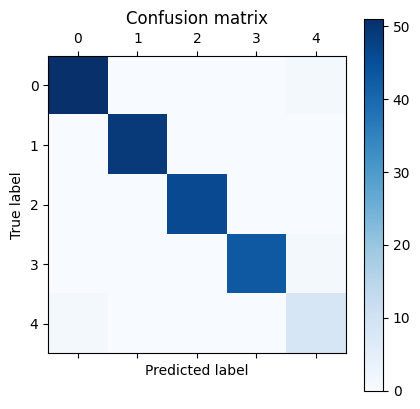

In [24]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.matshow(conf_matrix, cmap="Blues")
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.colorbar()
plt.show()

Please note that the data in this challenge is engineered to be easy to classify, so the accuracy is high. The goal was to test your knowledge in how to obtain the labels to train the model.